# Homework 2 : Exercise 1
***


In [628]:
import networkx as nx
import numpy as np
from itertools import groupby
from numpy.random import choice,random
import matplotlib.pyplot as plt
%matplotlib inline
import sys

np.random.seed(seed=42)
np.set_printoptions(precision=3, suppress= True)

We now define some useful matrices and vectors to perform all the simulations: 

 * $Λ$ is the matrix given and it is the transition rate matrix    
 * $ω$ is the vector containg the rates for the Poisson clocks associated with each node, obtained from the expression $ω_{i} = \sum_{j} Λ_{ij}$.
 * When we will use one global Poisson clock with rate $ω^{*} = max_{i} (ω_{i})$, we will refer to the matrix $Q$. It contains the conditional probabilities of jumping from a node i to a neighbor node $j$ or stay in node i when the global poisson clock at ticks: $Q_{ii} = 1 − \sum_{i\ne j} Q_{ij}$.
 * Instead if we want to use a single Poisson clock for every node i with rate $ω_{i}$ , we will use the matrix $P$. It contains the conditional probabilities of jumping from a node i to a node j when the poisson clock at node i ticks: $P_{ij} = \frac{Λ_{ij}}{ω_{i}}$.
 * The cumulative sums matrices $P_{cum}$ aand $Q_{cum}$ will be used in the following simulations.
 * The invariant probability vector $\bar{\pi}$, the i-th element contains the probability to end up in the i-th node.

To perform the simulations in this exercise, we will use the approach involving the use of a Poisson clock with rate $ω_{i}$ for every node i in our discrete state space, $\forall i \in \chi$.
***

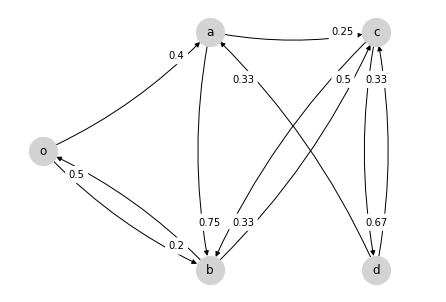

In [629]:
Lambda = [
    [0,   2/5, 1/5, 0,   0  ],
    [0,   0,   3/4, 1/4, 0  ],
    [1/2, 0,   0,   1/2, 0  ],
    [0,   0,   1/3, 0,   2/3],
    [0,   1/3, 0,   1/3, 0  ],
]

G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(2/5))), ('o', 'b', float("{0:.2f}".format(1/5))), 
                           ('a', 'b', float("{0:.2f}".format(3/4))), ('a', 'c', float("{0:.2f}".format(1/4))), 
                           ('b', 'o', float("{0:.2f}".format(1/2))), ('b', 'c', float("{0:.2f}".format(1/2))), 
                           ('c', 'b', float("{0:.2f}".format(1/3))), ('c', 'd', float("{0:.2f}".format(2/3))), 
                           ('d', 'a', float("{0:.2f}".format(1/3))), ('d', 'c', float("{0:.2f}".format(1/3)))])
pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,2),'d':(2,-2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightgray',  connectionstyle='arc3, rad = 0.1')
labels = {e: G.edges[e]['weight'] for e in G.edges}
val = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')

In [630]:
n_nodes = len(G.nodes)

w = np.sum(Lambda, axis=1)
w_star = np.max(w)

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda
P_cum = np.cumsum(P, axis=1)

Q = Lambda/w_star
Q = Q + np.diag(np.ones(len(w)) - np.sum(Q, axis=1))
Q_cum = np.cumsum(Q, axis = 1)

print("Number of nodes: ", n_nodes)
print("\Vector w:\n", w)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
#print("\nMatrix P_cum:\n", P_cum)
print("\nMatrix Q:\n", Q)
#print("\nMatrix Q_cum:\n", Q_cum)

Number of nodes:  5
\Vector w:
 [0.6   1.    1.    1.    0.667]

Matrix D:
 [[0.6   0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.667]]

Matrix P:
 [[0.    0.667 0.333 0.    0.   ]
 [0.    0.    0.75  0.25  0.   ]
 [0.5   0.    0.    0.5   0.   ]
 [0.    0.    0.333 0.    0.667]
 [0.    0.5   0.    0.5   0.   ]]

Matrix Q:
 [[0.4   0.4   0.2   0.    0.   ]
 [0.    0.    0.75  0.25  0.   ]
 [0.5   0.    0.    0.5   0.   ]
 [0.    0.    0.333 0.    0.667]
 [0.    0.333 0.    0.333 0.333]]


In [631]:
# Compute invariant distribution pi_bar
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.185 0.148 0.222 0.222 0.222]


##### A) What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?

In [632]:
#function for simulation a random walk on graph
def simulateRandomWalk(origin, destination, n_simulations = 10000):

    #t_next = -np.log(np.random.rand())/w[1] #Poissn clock of node 'a'

    array_return_time = np.zeros(n_simulations, dtype=float)

    for j in range(n_simulations): # iterate over simulations
        pos = []
        pos.append(origin) # node 1 -> 'a'
        transition_times = []
        transition_times.append(0)
        node_counter = 0
        t_next = -np.log(np.random.rand())/w_star

        while True:
            node_counter += 1
            # append index
            pos.append(np.argwhere(Q_cum[pos[node_counter-1]] > np.random.rand())[0][0])
            transition_times.append(transition_times[node_counter-1] + t_next)
            if pos[node_counter] == destination: #the particle is in node 'a' after exiting from it
                break
            t_next = -np.log(np.random.rand())/w_star


        array_return_time[j] = transition_times[-1]

    avg_return_time = np.mean(array_return_time)
    print("Average return time: {} s".format(avg_return_time))
    return avg_return_time

In [633]:
simulationAvgTime = simulateRandomWalk(origin=1, destination=1, n_simulations = 10000)

Average return time: 6.645609572207408 s


##### B) How does the result in A) compare to the theoretical return-time $\mathbb{E}_{a}[T_{a}^{+}]$ ?
The return-time is computed by appling the following formula: $\mathbb{E}_{i}[T_{i}^{+}] = \frac{1}{\omega_{i}\bar{\pi_{i}}}$,  where $\bar{\pi}$ is the
invariant probability vector.

In [634]:
#define the set S and the remaining nodes R
node = 1
S = [node]

#define the remaining nodes R
R = [node for node in range(n_nodes) if node not in S]

#restrict P to R x R and obtain hat(P)
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]

#hat(x) is the solution of the linear system
hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),(np.ones(n_nodes-len(S))/hatw))

#hitting time = 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)
#hitting time = hat(x) for nodes in R
hitting_s[R] = hatx

print('Expected hitting times on a: ',hitting_s)
expected_theoric = 1 / w[1] +  np.dot(P[1,:], hitting_s)
print('Expected return time: ',expected_theoric)
print("Error simulation",abs(simulationAvgTime - expected_theoric))

Expected hitting times on a:  [3.571 0.    5.714 5.857 4.429]
Expected return time:  6.75
Error simulation 0.104390427792592


##### C) What is, according to the simulations, the average time it takes to move from node o to node d?

In [635]:
simulationAvgTime = simulateRandomWalk(origin=0, destination=4, n_simulations=1000)

Average return time: 8.1396675878699 s


##### D) How does the result in C) compare to the theoretical hitting-time $\mathbb{E}_{o}[T_{d}]$? (Describe also how this is computed.)

In [636]:
node = 4 #node d
S = [node]
R = [node for node in range(n_nodes) if node not in S]

hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]

hatx = np.linalg.solve((np.identity(n_nodes - len(S)) - hatP), (np.ones(n_nodes - len(S)) / hatw))

hitting_s = np.zeros(n_nodes)
hitting_s[R] = hatx

expected_od = hitting_s[0]
print("Hitting time: {} time units ".format(expected_od))
print("Error simulation",abs(simulationAvgTime - expected_od))

Hitting time: 8.785714285714285 time units 
Error simulation 0.6460466978443851


##### E) Interpret the matrix $Λ$ as the weight matrix of a graph $G = (V, E, Λ)$, and simulate the French-DeGroot dynamics on G with an arbitrary initial condition $x(0)$. Does the dynamics converge to a consensus state? Motivate your answer.
Since the graph is strongly connected, in the condensation graph there is only a single sink. That sink is aperiodic and so x(t) converges to a consensus status.

The consensus state is: [0.304 0.304 0.304 0.304 0.304]
The consensus value is: 0.30434782608695654


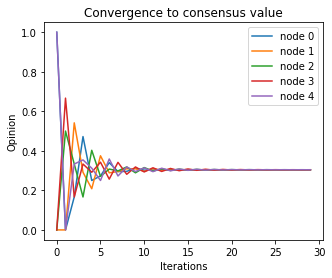

In [637]:
#number of iterations
n_iter = 30

# ksave the evolution of the consensus
x = np.zeros((len(G.nodes),n_iter))

# set initial condition (1,0,0,0,1)
x[:,0] = np.array([1,0,0,0,1])
# evolve the states
for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]
    
x[:,n_iter-1]

print("The consensus state is:", x[:,n_iter-1])

values,vectors = np.linalg.eig(P.T)

# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(len(G)) if np.isclose(values[i],1)]: 
    pi = vectors[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi)
#found pi, we have to multiply by the initial condition
x0 = x[:,0]

print("The consensus value is:", pi@x0)

#plot the record of the consensus vector to have a better look of the convergence
fig = plt.figure(1, figsize=(5,4))
ax = plt.subplot(111)

for node in range(G.number_of_nodes()):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()
ax.set_title("Convergence to consensus value")
plt.xlabel('Iterations')
plt.ylabel('Opinion')
plt.savefig("Ex1_E.svg")
plt.show()

##### F) Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_{i}(0) = \xi_{i}$ , where ${\xi_{i}}_{i \in V}$ are i.i.d random variables with variance $\sigma^{2}$ . Compute the variance of the consensus value, and compare your results with numerical simulations.

In [638]:
alfa_err = np.zeros(200)

#with numerical simulations
for i in range(200):
    
    #since rand returns random values in [0,1], mu = 1/2
    x = np.random.rand(5)
    for n in range(500):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x)) * (1/2 - np.mean(x))

print("The variance of the consensus state is:", np.mean(alfa_err), "\n")

values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
#uniform distribution, so the variance is 1/12
sigma = 1/12
print("Expected variance:", np.sum(np.square(pi))*1/12)


The variance of the consensus state is: 0.021506366564129156 

Expected variance: 0.017032464563328766


##### G) Remove the edges $(d, a)$ and $(d, c)$. Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition $x(0)$? Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_{i}(0) = \xi_{i}$ , where ${\xi_{i}}_{i \in V}$ are i.i.d random variables with variance $\sigma^{2}$ . Compute the variance of the consensus value. Motivate your answer.

Arbitary initial condition x(0): [0.764 0.723 0.04  0.124 0.794]
The asymptotic state x is: [0.794 0.794 0.794 0.794 0.794]
The variance of the consensus state is: 0.07852765531998336 



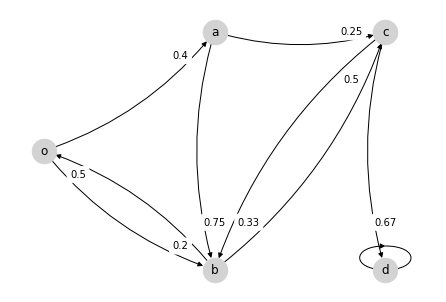

In [639]:
#remove edges
G.remove_edges_from([('d', 'a'), ('d', 'c')])
#add self loop to d
G.add_weighted_edges_from([('d', 'd', float("{0:.2f}".format(1/10000)))])
pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,2),'d':(2,-2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 600, font_size=12, node_color='lightgray',  connectionstyle='arc3, rad = 0.15')
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')

#calculate P
W = nx.adjacency_matrix(G)
W = W.toarray()
W[4][4] = 0.00001   #self loop weight lowest possible
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

n_iter = 70

#arbitrary initial condition
x = np.random.rand(5)
print('Arbitary initial condition x(0):', x)

for i in range(n_iter):
    x = P @ x
print("The asymptotic state x is:", x)

#with numerical simulations
for i in range(200):
    
    #since rand returns random values in [0,1], mu = 1/2
    x = np.random.rand(5)
    var = np.var(x)
    for n in range(500):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x)) * (1/2 - np.mean(x))
    
print("The variance of the consensus state is:", np.mean(alfa_err), "\n")

##### H) Consider the graph $G = (V, E, \Lambda)$, and remove the edges $(c, b)$ and $(d, a)$.  Analyse the French- DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition $x(0)$.

Arbitary initial condition x(0): [0.664 0.536 0.895 0.286 0.917]
Final opinions: [0.626 0.65  0.431 0.917 0.286]


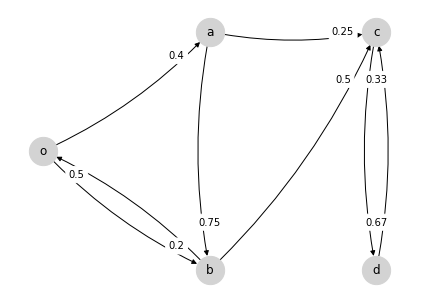

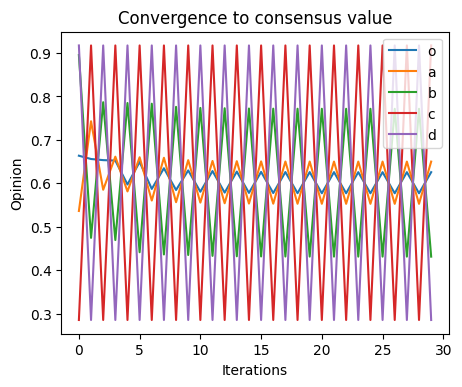

In [640]:
#reconstruct the new graph
G = nx.DiGraph()
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(2/5))), ('o', 'b', float("{0:.2f}".format(1/5))), 
                           ('a', 'b', float("{0:.2f}".format(3/4))), ('a', 'c', float("{0:.2f}".format(1/4))), 
                           ('b', 'o', float("{0:.2f}".format(1/2))), ('b', 'c', float("{0:.2f}".format(1/2))), 
                           ('c', 'd', float("{0:.2f}".format(2/3))), ('d', 'c', float("{0:.2f}".format(1/3)))])

pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,2),'d':(2,-2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightgray',  connectionstyle='arc3, rad = 0.1')
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')

#reconstruct P
W = nx.adjacency_matrix(G)
W = W.toarray()
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

n_iter = 30

x = np.zeros((5,n_iter))
#arbitrary initial condition
x[:,0] = np.random.rand(5)
print('Arbitary initial condition x(0):', x[:,0])

# evolve the states
for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]

print("Final opinions:", x[:,n_iter-1])

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = plt.subplot(111)
node_names = ['o', 'a', 'b', 'c', 'd']
  
for node in range(5):
    op = x[node,:]
    ax.plot(range(n_iter), op, label=f'{node_names[node]}')
      
ax.legend()
ax.set_title("Convergence to consensus value")
plt.xlabel('Iterations')
plt.ylabel('Opinion')
plt.savefig("Ex1_H.svg")
plt.show()

# Homework 2 - Exercise 2

### A) Particle Perspective 

#####  $\bullet$ If 100 particles all start in node a, what is the average time for a particle to return to node a?
For this simulation, we will use the approach involving the use of a Poisson clock with rate $ω_{i}$ for every node i in our discrete state space, $\forall i \in \chi$.

In [641]:
particles = np.array(range(100)).astype(np.int32)
simulationAvgTime = simulateRandomWalk(origin=1, destination=1, n_simulations= len(particles)*1000)
print(simulationAvgTime)
print("Error simulation",abs(simulationAvgTime - expected_theoric))

Average return time: 6.764747790576242 s
6.764747790576242
Error simulation 0.014747790576241648


##### $\bullet$ How does this compare to the answer in Problem 1, why?
Since all the particles are independent and identically distributed, the simulation of a random walk with 100 particles is equal to simulating a random walk with one particle 100 times. But, instead of computing the average for each particle (1000 simulation for each one) and then the average over the 100 particles, we can just compute one hundred *1000 simulations* (in exercise *1.a* there were performed 1000 simulations for 1 particle).
Here the number of simulations is equal to the number of particles (100).

### B) Node perspective:

##### $\bullet$ If 100 particles start in node o, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?

For this simulation, we use a global Poisson clock with rate 100 as the number of particles in the system.

In [642]:
# stating with 100 particles in node 'o'
n_particles=100  # Equal to the rate
time_units = 60
hist_nodes = np.array([[100, 0, 0, 0, 0 ]], dtype=float)

n_nodes = np.zeros(len(G.nodes), dtype = float)
n_nodes[0] = n_particles
P_nodes = n_nodes/n_particles
P_nodes_cum = np.cumsum(P_nodes)

transition_times = []
transition_times.append(0)

t_next = -np.log(np.random.rand())/n_particles
i = 0

timeSeq = []
timeSeq.append(0)

while transition_times[i] < time_units:
    i += 1

    transition_times.append(transition_times[i-1] + t_next )
    timeSeq.append(transition_times[-1])

    start_index = np.argwhere(P_nodes_cum > np.random.rand())[0][0]
    dest_index = np.argwhere(Q_cum[start_index] >= np.random.rand())[0][0]

    n_nodes[dest_index] += 1
    n_nodes[start_index] -= 1 
    
    hist_nodes = np.concatenate((hist_nodes, [n_nodes]), axis = 0)

    P_nodes=n_nodes/n_particles
    P_nodes_cum = np.cumsum(P_nodes)

    t_next = -np.log(np.random.rand())/n_particles
    
avg_particles = {}
for nodes, avg_value in zip(G.nodes, np.average(hist_nodes, axis=0)):
    avg_particles[nodes] = round(avg_value, 2)

print("Particles per node at final step: ", avg_particles)
print("Average number of particles in every node pi_bar: ", 100*pi_bar)

Particles per node at final step:  {'o': 21.62, 'a': 14.04, 'b': 21.87, 'c': 21.22, 'd': 21.24}
Average number of particles in every node pi_bar:  [18.519 14.815 22.222 22.222 22.222]


If we compare the previous results with the stationary distribution of the continuous-time $\bar{\pi}$, we can see that they are close.
***
##### $\bullet$ Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.

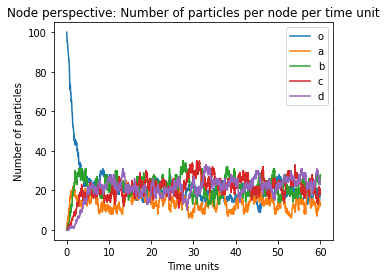

In [643]:
fig, ax = plt.subplots(figsize=(5,4)) 
labels = dict(enumerate(G.nodes))

for i in range(len(G)):
    ax.plot(timeSeq, hist_nodes[:, i], label=labels[i])
    
ax.legend()
ax.set_title("Node perspective: Number of particles per node per time unit")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("Ex2_B.svg")
plt.show()

# Homework 2 - Exercise 3

In this system, particles enter the system at node o according to a Poisson process with rate $\lambda=1$. Each node will then pass on a particle at some rate, similar to what we did in Problem 2 with the "node perspective." Note that node d has no node to which it can send its particle. If the Poisson clock is ticking for this node, you can simply decrease the number of particles in this node by one (if there are any particles in this node at all). Equivalently think of another node d' connected to node d, such that at every tick of the Poisson clock of d, it sends one particle to node d'.

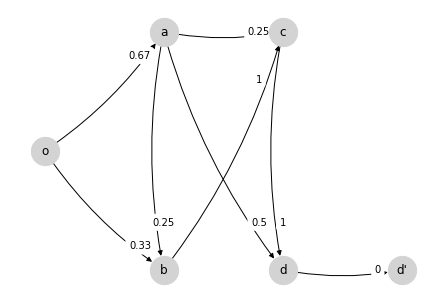

In [644]:
# draw graph
G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d', "d'"])
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(2/3))), ('o', 'b', float("{0:.2f}".format(1/3))), 
                           ('a', 'b', float("{0:.2f}".format(1/4))), ('a', 'c', float("{0:.2f}".format(1/4))), 
                           ('a', 'd', float("{0:.2f}".format(2/4))), ('b', 'c',1), ('c','d',1), ('d', "d'", 0)])
pos = nx.spring_layout(G)
pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,2),'d':(2,-2), "d'":(3, -2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightgray',  connectionstyle='arc3, rad = 0.1')
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')

Lambda_open = [ [0,  2/3, 1/3, 0,   0],
                [0,  0,   1/4, 1/4, 2/4],
                [0,  0,   0,   1,   0],
                [0,  0,   0,   0,   1],
                [0,  0,   0,   0,   0],
]

In [645]:
w = np.sum(lambda_matrix, axis=1)

G_nodes = len(G.nodes)

w_star = np.max(w)
Q = lambda_matrix/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)

print("Number of nodes: ", n_nodes)
print("\nVector w:\n", w)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
print("\nMatrix P_cum:\n", P_cum)
print("\nMatrix Q:\n", Q)
print("\nMatrix Q_cum:\n", Q_cum)

Number of nodes:  [18. 13. 28. 18. 23.]

Vector w:
 [1. 1. 1. 1. 1. 0.]

Matrix D:
 [[0.6  0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.67 0.  ]
 [0.   0.   0.   0.   0.33]]

Matrix P:
 [[0.    0.667 0.333 0.    0.   ]
 [0.    0.    0.75  0.25  0.   ]
 [0.5   0.    0.    0.5   0.   ]
 [0.    0.    0.    0.    1.   ]
 [0.    0.    0.    1.    0.   ]]

Matrix P_cum:
 [[0.    0.667 1.    1.    1.   ]
 [0.    0.    0.75  1.    1.   ]
 [0.5   0.5   0.5   1.    1.   ]
 [0.    0.    0.333 0.333 1.   ]
 [0.    0.5   0.5   1.    1.   ]]

Matrix Q:
 [[0.    0.667 0.333 0.    0.    0.   ]
 [0.    0.    0.25  0.25  0.5   0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    1.   ]]

Matrix Q_cum:
 [[0.    0.667 1.    1.    1.    1.   ]
 [0.    0.    0.25  0.5   1.    1.   ]
 [0.    0.    0.    1.    1.    1.   ]
 [0.    0.    0.    0.    1.    1. 

### A) Proportional rate
The rate of the Poisson clock of each node is equal to the number of particles in it.
##### $\bullet$ Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.
##### $\bullet$ What is the largest input rate that the system can handle without blowing up?

In [646]:
def get_starting_node(node_particles, rate):
    particles = rate

    # 1 dummy variable for entry in node 'o'
    # Particles in nodes
    n_nodes = np.zeros(G_nodes)
    n_nodes[5] = rate

    particles += np.sum(node_particles)

    for i in range(G_nodes-1):
        n_nodes[i] = node_particles[i]

    particles_cum = np.cumsum(n_nodes)/particles
    start_node = np.argwhere(particles_cum > np.random.rand())[0][0]
    #print(start_node)

    return start_node, particles

def simulate_proportional_rate(time_units, rate):
    #particles in node
    node_particles = np.zeros(G_nodes-1)

    transition_times = []
    transition_times.append(0)

    hist_nodes = np.array([[0, 0, 0, 0, 0]])

    while True:

        start_node, particles = get_starting_node(node_particles, rate)
        t_next = transition_times[-1] - np.log(np.random.rand()) / particles
        
        # check dummy variable
        if start_node == 5:
            node_particles[0] += 1 

        elif start_node == 4:
            node_particles[4] -= 1 

        else:
            end_node = np.argwhere(Q_cum[start_node] > np.random.rand())[0][0]
            node_particles[start_node] -= 1 
            node_particles[end_node] += 1

        transition_times.append(t_next)

        hist_nodes = np.concatenate((hist_nodes, [node_particles]), axis = 0)
        
        if t_next > time_units:
            break

    return hist_nodes, transition_times

In [647]:
def plot_proportional_trajectories(transition_times, hist_nodes, input_rate):
    fig, ax = plt.subplots(figsize=(5,4), dpi=100)
    labels={0:'o',1:'a',2:'b',3:'c',4:'d'}
    for i in range(G_nodes-1): #only 5 nodes, excluding d'
        ax.plot(transition_times, hist_nodes[:, i], label=labels[i])

    ax.legend()
    plt.xlabel("Time units")
    plt.ylabel("Number of particles")
    plt.title("Input rate = {}".format(input_rate))
    plt.savefig("ParticlesProportionalRate"+str(input_rate)+".svg")
    plt.show()
    plt.close()

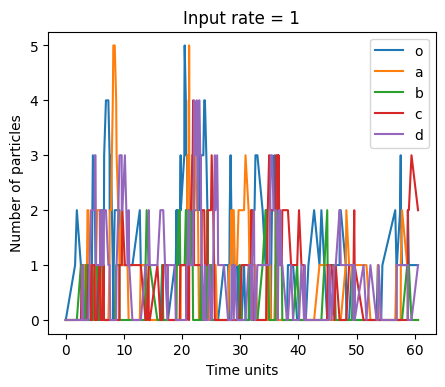

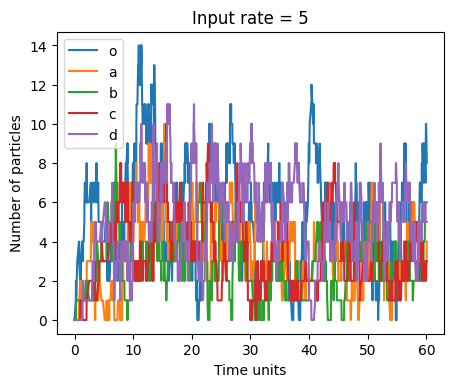

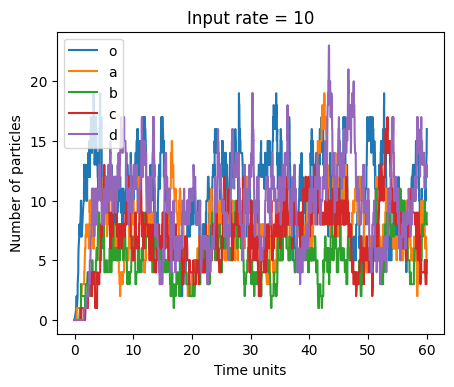

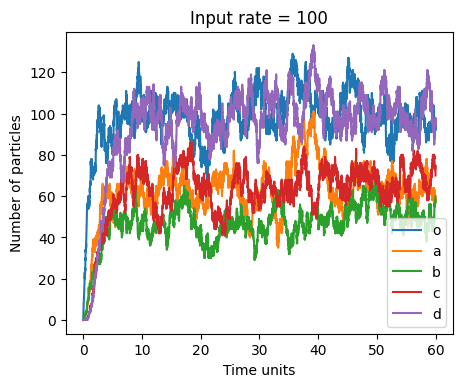

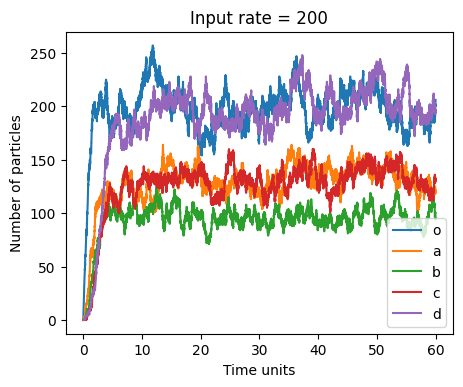

In [648]:
input_rates = [1, 5, 10, 100, 200]
time_units =60
for input_rate in input_rates:
    hist_nodes, transition_times = simulate_proportional_rate(time_units, input_rate)
    plot_proportional_trajectories(transition_times, hist_nodes, input_rate)

For the simulation we set 5 different input rates: 1, 5, 10, 100, 200. Higher value take too much computational time.
We can see the system does not blow up, in particular, particles do not accumulate in node ‘o’ and they move around the graph. This is due to the proportional rate of the global clock, the more particles are in the graph, the more the rate is higher. So each node is able to pass along its particles to other nodes.
***
### B)Fixed Rates
The rate of the Poisson clock of each node is fixed, and equal to one.
##### $\bullet$ Simulate the system for 60 time units and plot the evolution of number of particles in each node over time.
##### $\bullet$ What is the largest input rate that the system can handle without blowing up? Why is this different from the other case?

In [649]:
def get_starting_node(rate):
    total_rate = rate

    # 1 dummy variable for entry in node 'o'
    n_nodes = np.zeros(G_nodes)
    n_nodes[5] = rate
        
    for i in range(G_nodes-1):
        n_nodes[i] = 1
        total_rate += 1
    
    particles_cum = np.cumsum(n_nodes)/total_rate
    start_node = np.argwhere(particles_cum > np.random.rand())[0][0]
    
    return start_node, total_rate

def simulate_fixed_rate(time_units, rate):
    
    node_particles = np.zeros(G_nodes-1)

    transition_times = []
    transition_times.append(0)

    hist_nodes = np.array([[0, 0, 0, 0, 0]])

    while True:

        start_node, total_rate = get_starting_node(rate)
        t_next = transition_times[-1] - np.log(np.random.rand()) / total_rate
       
        # check dummy variable
        if start_node == 5:
            node_particles[0] += 1 
        
        elif node_particles[start_node] == 0:
            # Do nothing if I don't have any particle
            # Check after if start_nod == 5 but before start_node == 4.
            pass      

        elif start_node == 4:
            node_particles[4] -= 1 

        else:
            end_node = np.argwhere(Q_cum[start_node] > np.random.rand())[0][0]
            node_particles[start_node] -= 1 
            node_particles[end_node] += 1

        transition_times.append(t_next)
        hist_nodes = np.concatenate((hist_nodes, [node_particles]), axis = 0)
        
        if t_next > time_units:
            break

    return hist_nodes, transition_times

In [650]:
def plot_fixed_rate_trajectories(transition_times, hist_nodes, input_rate):
    fig, ax = plt.subplots(figsize=(5,4), dpi=100)
    labels={0:'o',1:'a',2:'b',3:'c',4:'d'}
    for i in range(G_nodes-1): #only 5 nodes, excluding d'
        ax.plot(transition_times, hist_nodes[:, i], label=labels[i])

    ax.legend()
    plt.xlabel("Time units")
    plt.ylabel("Number of particles")
    plt.title("Input rate = {}".format(input_rate))
    plt.savefig("ParticlesFixedRate"+str(input_rate)+".svg")
    plt.show()
    plt.close()

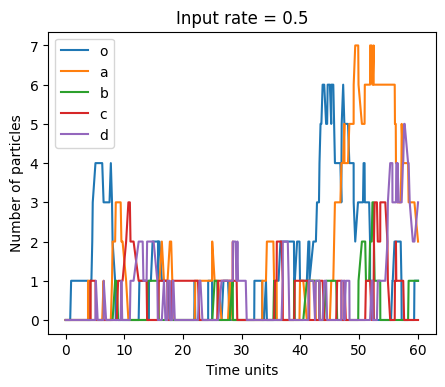

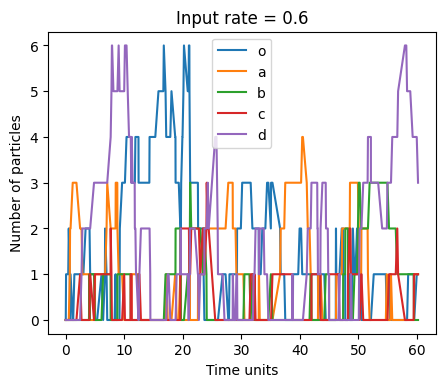

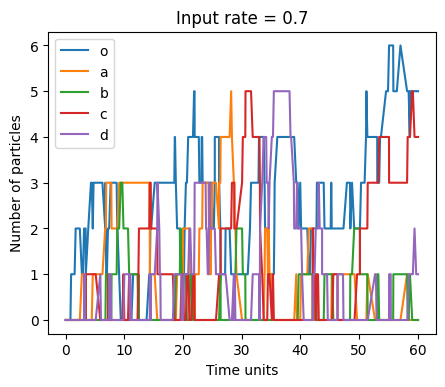

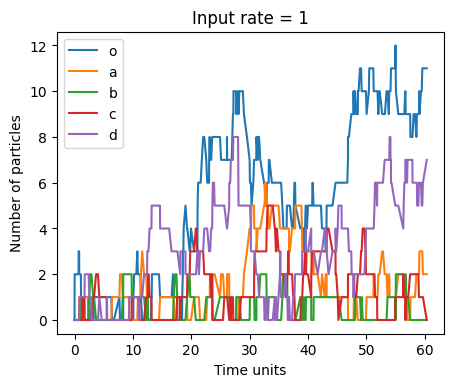

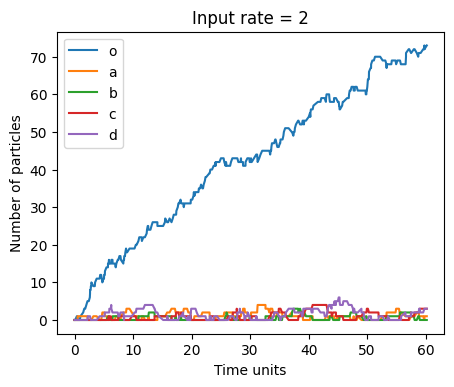

In [651]:
input_rates = [0.5, 0.6, 0.7, 1, 2]
time_units =60
for input_rate in input_rates:
    hist_nodes, transition_times = simulate_fixed_rate(time_units, input_rate)
    plot_fixed_rate_trajectories(transition_times, hist_nodes, input_rate)

We simulate the rate case with 5 different input rates: 0.5, 0.6, 0.7, 1, 2.
In this scenario we can clearly see that particles accumulate in node ‘o’ causing the blow-up. From the plot we can identify the crucial input rate between 0.6 and 0.7